# Preprocessing

Importing needed libraries

In [1]:
!pip install -q scikit-optimize

In [2]:
!pip install -q scikit-learn==1.3.0

In [3]:
!pip install -q umap-learn

In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dask
import joblib
import warnings
from dask.distributed import LocalCluster, Client
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, TargetEncoder
from sklearn.base import TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, f1_score, confusion_matrix, precision_recall_curve
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from umap import UMAP
from scipy.stats import randint, uniform
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings('ignore')

Initialize cluster

In [3]:
cluster = LocalCluster(n_workers = 4, threads_per_worker = 1, memory_limit = '6GB')
client = Client(cluster)

Reading csv file

In [4]:
df = pd.read_csv('Churn.csv', low_memory = False)
df.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


Checking dtypes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71047 entries, 0 to 71046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 71047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             70831 non-null  float64
 3   MonthlyMinutes             70831 non-null  float64
 4   TotalRecurringCharge       70831 non-null  float64
 5   DirectorAssistedCalls      70831 non-null  float64
 6   OverageMinutes             70831 non-null  float64
 7   RoamingCalls               70831 non-null  float64
 8   PercChangeMinutes          70545 non-null  float64
 9   PercChangeRevenues         70545 non-null  float64
 10  DroppedCalls               71047 non-null  float64
 11  BlockedCalls               71047 non-null  float64
 12  UnansweredCalls            71047 non-null  float64
 13  CustomerCareCalls          71047 non-null  flo

Verifying null values

In [6]:
# grabbing all missing values
total_missing = df.isnull().sum().reset_index().rename(columns = {'index': 'feature', 0: 'missing_count'})

# selecting ones whic have missing_count greater than 0
actual_missing = total_missing[total_missing.missing_count > 0].copy().reset_index(drop = True)

# showing in terms of relative percentages
actual_missing['missin_count_relavite'] = actual_missing['missing_count'] / len(df)

# adding its dtypes
dtype_dict = df.dtypes.to_dict()
actual_missing['dtype'] = actual_missing.feature.map(dtype_dict)

# missing dataframe
actual_missing

,feature,missing_count,missin_count_relavite,dtype
0,Churn,20000,0.281504,object
1,MonthlyRevenue,216,0.003040,float64
2,MonthlyMinutes,216,0.003040,float64
3,TotalRecurringCharge,216,0.003040,float64
4,DirectorAssistedCalls,216,0.003040,float64
5,OverageMinutes,216,0.003040,float64
6,RoamingCalls,216,0.003040,float64
7,PercChangeMinutes,502,0.007066,float64
8,PercChangeRevenues,502,0.007066,float64
9,ServiceArea,28,0.000394,object


As it can be seen, there are 20000 missing values on the target "Churn", this group is stored in another datadrame for future purposes, but as first step we clean the null values by dropping their rows cause they represent fewer than 2%

In [7]:
# drop null values
values_to_drop = actual_missing.feature.tolist()[1:]

df = df.dropna(subset = values_to_drop, axis = 0)

# getting those
df_no_target = df[df.Churn.isnull()].copy().reset_index(drop = True)

# dropping 20000 nan values in the original dataframe
df = df.dropna(subset = 'Churn')

# removing churn feature from actual_missing
actual_missing = actual_missing[actual_missing.feature != 'Churn']

# verifying new shape
df.shape

(49752, 58)

Verifying null values

In [8]:
df.isnull().sum().sum()

0

Labeling target

In [9]:
df['Churn'] = np.where(df['Churn'] == 'Yes', 1, 0)

Creating a class to clean outliers

In [10]:
class CleanOutliers(TransformerMixin):
    def __init__(self):
        '''
        Treat outliers
        '''
    def set_output(self, transform = 'pandas'):
        return self

    def _get_boundaries(self, X_feature):
        q1 = X_feature.quantile(0.25)
        q3 = X_feature.quantile(0.75)
        irs = q3 - q1
        lower_bound = q1 - 1.5 * irs
        upper_bound = q3 + 1.5 * irs
        return lower_bound, upper_bound

    def fit(self, X, y = None):
        self.boundary = {column: self._get_boundaries(X[column]) for column in X.columns}
        return self

    def transform(self, X, y = None):
        X_gei = X.copy()
        current_columns = X_gei.columns.tolist()
        for column in current_columns:
            lower_bound, upper_bound = self.boundary[column]
            X_gei[column] = X_gei[column].clip(lower = lower_bound,
                                        upper = upper_bound)
        return X_gei.copy()

Verfying categorical values before performing encoding

In [11]:
cat_features = df.describe(include = object).T
cat_features_to_regroup = cat_features[cat_features.unique > 4]
cat_features_to_regroup

,count,unique,top,freq
ServiceArea,49752,743,NYCBRO917,1646
HandsetPrice,49752,16,Unknown,28263
CreditRating,49752,7,2-High,18692
Occupation,49752,8,Other,36453


Selecting those columns to check on its values

In [12]:
df_cat_features_to_regroup = df[['ServiceArea', 'HandsetPrice', 'CreditRating', 'Occupation']]
df_cat_features_to_regroup

,ServiceArea,HandsetPrice,CreditRating,Occupation
0,SEAPOR503,30,1-Highest,Professional
1,PITHOM412,30,4-Medium,Professional
2,MILMIL414,Unknown,3-Good,Crafts
3,PITHOM412,10,4-Medium,Other
4,OKCTUL918,10,1-Highest,Professional
...,...,...,...,...
51035,NEVELC619,Unknown,2-High,Professional
51037,NEVENC760,Unknown,3-Good,Other
51040,LAXVNY818,Unknown,1-Highest,Professional
51041,LAXDOW562,30,5-Low,Professional


Value counts per cat feature

In [13]:
df.ServiceArea.value_counts()

NYCBRO917    1646
DALDAL214    1479
HOUHOU281    1471
NYCMAN917    1156
DALFTW817     771
             ... 
SANROM956       1
INDCRA765       1
SEWSUN509       1
ATLDBL478       1
NCRDNN910       1
Name: ServiceArea, Length: 743, dtype: int64

In [14]:
df.HandsetPrice.value_counts()

Unknown    28263
30          7147
150         4024
130         2043
80          1901
10          1869
60          1730
200         1227
100         1209
40           240
400           45
250           20
300           12
180            9
500            7
240            6
Name: HandsetPrice, dtype: int64

Creating a function to regroup specific features

In [15]:
df.HandsetPrice.unique()

array(['30', 'Unknown', '10', '80', '150', '300', '40', '200', '100',
       '130', '60', '400', '240', '250', '180', '500'], dtype=object)

In [16]:
def regroup_cat_values(data):
    # ServiceArea
    top_4 = df.ServiceArea.value_counts().head(4).index.tolist()
    data['ServiceArea'] = np.where(data['ServiceArea'].isin(top_4),
                                    data['ServiceArea'],
                                    'OTHER')
    # HandsetPrice
    data['HandsetPrice'] = np.where(data['HandsetPrice'] == 'Unknown', '30', data['HandsetPrice'])
    data['HandsetPrice'] = data['HandsetPrice'].astype('int16')

    return data

Apply the function to both dataframes

In [17]:
df = regroup_cat_values(df)
df_no_target = regroup_cat_values(df_no_target)

In [18]:
df.describe(include = object).T

,count,unique,top,freq
ServiceArea,49752,5,OTHER,44000
ChildrenInHH,49752,2,No,37483
HandsetRefurbished,49752,2,No,42852
HandsetWebCapable,49752,2,Yes,44905
TruckOwner,49752,2,No,40280
RVOwner,49752,2,No,45619
Homeownership,49752,2,Known,33725
BuysViaMailOrder,49752,2,No,31432
RespondsToMailOffers,49752,2,No,30667
OptOutMailings,49752,2,No,49006


It is observed that can be label encoded is CreditRating

In [19]:
df.CreditRating.unique()

array(['1-Highest', '4-Medium', '3-Good', '2-High', '5-Low', '6-VeryLow',
       '7-Lowest'], dtype=object)

Creating a local class for label encoding

Splitting dataframe

In [20]:
# Getting X and y matrices
X = df.drop(columns = ['CustomerID','Churn'])
y = df.Churn

# splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 24)

Performing the final treatment

In [21]:
# selecting dtypes
num_col = X_train.select_dtypes(include = np.number).columns.tolist()
cat_col = X_train.select_dtypes(include = ['object', 'category']).columns.tolist()

# creating pipelines or transformers
num_prep = Pipeline([('outlier', CleanOutliers().set_output(transform ='pandas')),
                    ('impute', SimpleImputer(strategy = 'mean').set_output(transform = 'pandas'))])

cat_prep = TargetEncoder(random_state=23).set_output(transform = 'pandas')

# creating transformer
column_transformer = ColumnTransformer([('num', num_prep, num_col),
                                        ('cat', cat_prep, cat_col)],
                                        remainder = 'passthrough')\
                                    .set_output(transform = 'pandas')

# testing transformer
X_train_tr = column_transformer.fit_transform(X_train, y_train)

Removing multivariate outliers from testing set

In [22]:
# In order to verify outlier groups, it is important to reduce the data into a two-featured one so that the
# minority class would be considered as outlier
min_samples = len(X_train) * 0.05
reducer = UMAP(n_components = 2, random_state = 23)
detector = DBSCAN(eps = 1.2, min_samples = int(min_samples), n_jobs = -1)
# scaling
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_tr)
# reducing
X_train_re = reducer.fit_transform(X_train_sc)
# detecting labels
labels = detector.fit_predict(X_train_re)

Plotting classes

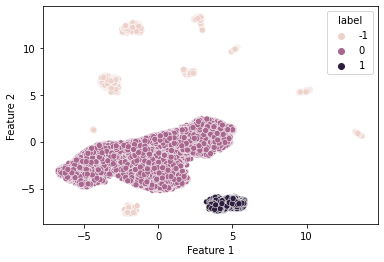

In [23]:
evaluator = pd.DataFrame(X_train_re, columns = ['Feature 1', 'Feature 2'])
outlier = pd.DataFrame(labels, columns = ['label'])
evaluator = pd.concat([evaluator, outlier], axis = 1)
sns.scatterplot(evaluator, x = 'Feature 1', y = 'Feature 2', hue = 'label')
plt.show()

Creating a class to clean multivariate outliers

In [24]:
class MultivariateOutliers(BaseEstimator, TransformerMixin):
    def __init__(self):
        """
        Removes outliers
        """
    def set_output(self, transform = 'pandas'):
        return self

    def fit(self, X, y = None):
        scaler = StandardScaler()
        reducer = UMAP(n_components = 2, random_state = 23)
        self.pipe_transform = make_pipeline(scaler, reducer)
        self.pipe_transform.fit(X)
        return self

    def transform(self, X, y):
        min_samples = len(X) * 0.05
        X_tr = self.pipe_transform.transform(X)
        detector = DBSCAN(eps = 1.2, min_samples = int(min_samples), n_jobs = -1)
        labels = detector.fit_predict(X_tr)
        outlier = pd.DataFrame(labels, columns = ['label'])
        df = pd.concat([X, y], axis = 1).reset_index(drop = True)
        data = pd.concat([df, outlier], axis = 1)
        most_common = data.label.value_counts().index.values[0]
        data = data[data['label'] == most_common].drop(columns = 'label')
        return data.drop(columns = 'Churn'), data.Churn

Removing outliers

In [25]:
# declaring outlier detector
outlier_removal = MultivariateOutliers()

# transform features
X_train_tr = column_transformer.fit_transform(X_train, y_train)
X_test_tr = column_transformer.transform(X_test)

# removing outliers
outlier_removal.fit(X_train_tr)
X_train_tr, y_train = outlier_removal.transform(X_train_tr, y_train)

Count correlations which values are either greater than 0.6 or fewer than -0.6 (not counting 1)

In [26]:
((X_train_tr.corr() != 1) & (X_train_tr.corr() > 0.6)).sum().sum() / 2

49.0

In [31]:
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X_train_tr.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X_train_tr.values, i) 
                          for i in range(len(X_train_tr.columns))]
vif_data.head()

,feature,VIF
0,num__MonthlyRevenue,32.713074
1,num__MonthlyMinutes,13.270049
2,num__TotalRecurringCharge,22.962663
3,num__DirectorAssistedCalls,2.092350
4,num__OverageMinutes,5.498395


Removing ones that have a VIF value greater than 5

In [32]:
selected_features = vif_data.loc[vif_data['VIF'] <= 5, 'feature'].values.tolist()

In [33]:
# it can be observed that new VIF values are acceptable
vif_data = pd.DataFrame() 
vif_data["feature"] = X_train_tr[selected_features].columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X_train_tr[selected_features].values, i) 
                          for i in range(len(X_train_tr[selected_features].columns))]
vif_data

,feature,VIF
0,num__DirectorAssistedCalls,1.665435
1,num__RoamingCalls,1.303639
2,num__PercChangeMinutes,1.473668
3,num__PercChangeRevenues,1.543727
4,num__CustomerCareCalls,1.772625
5,num__ThreewayCalls,1.476549
6,num__InboundCalls,2.307753
7,num__CallWaitingCalls,2.530463
8,num__AgeHH2,1.231370


Selecting filtered features

In [43]:
X_train_sel = X_train_tr[selected_features].copy()
X_test_sel = X_test_tr[selected_features].copy()

# Data Modelling

Creating a function to evaluate performance

In [35]:
def evaluation_metric(model_name, y_train_actual, y_train_pred, y_test_actual, y_test_pred):

    recall_train = recall_score(y_train_actual, y_train_pred)
    recall_test = recall_score(y_test_actual, y_test_pred)

    precision_train = precision_score(y_train_actual, y_train_pred)
    precision_test = precision_score(y_test_actual, y_test_pred)

    f1_train = f1_score(y_train_actual, y_train_pred)
    f1_test = f1_score(y_test_actual, y_test_pred)

    accuracy_train = accuracy_score(y_train_actual, y_train_pred)
    accuracy_test = accuracy_score(y_test_actual, y_test_pred)

    # Table creation
    results_dict = {f'{model_name} Train set': [recall_train, precision_train, f1_train, accuracy_train],
                f'{model_name} Test set': [recall_test, precision_test, f1_test, accuracy_test]}

    results = pd.DataFrame(results_dict, index = ['Recall Score', 'Precision Score', 'F1 Score', 'Accuracy Score'])
    return results

Creating base models

In [45]:
# X and y matrices
X_chosen = X_train_sel.copy()
y_chosen = y_train.copy()

# params for boosting
ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
# classifiers and scaler
scaler = StandardScaler()
lr = LogisticRegression(class_weight = 'balanced', random_state = 24, n_jobs = -1)
knn = KNeighborsClassifier(weights = 'distance', n_jobs = -1)
dtc = DecisionTreeClassifier(class_weight = 'balanced', random_state = 24)
rfc = RandomForestClassifier(class_weight = 'balanced', random_state = 24)
xgb = XGBClassifier(scale_pos_weight = ratio * 1.4, random_state = 24, n_jobs = -1)
lgbm = LGBMClassifier(scale_pos_weight = ratio * 1.4, random_state = 24, n_jobs = -1)

# declaring pipelines
lr_pipe = Pipeline([('sc', scaler), ('clf', lr)])
knn_pipe = Pipeline([('sc', scaler), ('clf', knn)])
dtc_pipe = Pipeline([('sc', scaler), ('clf', dtc)])
rfc_pipe = Pipeline([('sc', scaler), ('clf', rfc)])
xgb_pipe = Pipeline([('sc', scaler), ('clf', xgb)])
lgbm_pipe = Pipeline([('sc', scaler), ('clf', lgbm)])

# fitting pipelines
with joblib.parallel_backend('dask', scatter = (X_chosen, y_chosen)):
    lr_pipe.fit(X_chosen, y_chosen)
    knn_pipe.fit(X_chosen, y_chosen)
    dtc_pipe.fit(X_chosen, y_chosen)
    rfc_pipe.fit(X_chosen, y_chosen)
    xgb_pipe.fit(X_chosen, y_chosen)
    lgbm_pipe.fit(X_chosen, y_chosen)

[LightGBM] [Info] Number of positive: 8650, number of negative: 23176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 31826, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.271790 -> initscore=-0.985558
[LightGBM] [Info] Start training from score -0.985558


Base metrics

In [46]:
total_metrics = pd.DataFrame()

pipes = [('LR', lr_pipe), ('KNN', knn_pipe), ('DTC', dtc_pipe),
         ('RFC', rfc_pipe), ('XGB', xgb_pipe), ('LGBM', lgbm_pipe)]

for clf_name, clf in pipes:
    y_train_pred = clf.predict(X_train_sel)
    y_test_pred = clf.predict(X_test_sel)

    result = evaluation_metric(clf_name, y_train, y_train_pred, y_test, y_test_pred)

    total_metrics = pd.concat([total_metrics, result], axis = 1)

total_metrics

,LR Train set,LR Test set,KNN Train set,KNN Test set,DTC Train set,DTC Test set,RFC Train set,RFC Test set,XGB Train set,XGB Test set,LGBM Train set,LGBM Test set
Recall Score,0.590058,0.618143,0.976416,0.169480,0.996763,0.302743,0.993295,0.084037,0.943006,0.634318,0.961734,0.822785
Precision Score,0.296279,0.320861,0.987028,0.328114,0.963460,0.312070,0.969095,0.388618,0.445348,0.307902,0.335931,0.298127
F1 Score,0.394482,0.422444,0.981693,0.223510,0.979828,0.307335,0.981046,0.138190,0.604984,0.414570,0.497935,0.437670
Accuracy Score,0.507667,0.516933,0.990102,0.663451,0.988846,0.609989,0.989568,0.700432,0.665305,0.487991,0.472884,0.395739


# Hyperparameter Tuning Search :)

Setting a function to compare metrics

In [53]:
def compare_base_tuner(name, base_pipe, tuned_pipe, X_train, X_test, y_train, y_test):
    total_metrics = pd.DataFrame()
    pipes = [(name, base_pipe), (f'{name}_TUNED', tuned_pipe.best_estimator_)]

    for clf_name, clf in pipes:
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)

        result = evaluation_metric(clf_name, y_train, y_train_pred, y_test, y_test_pred)

        total_metrics = pd.concat([total_metrics, result], axis = 1)

    return total_metrics

Confusion Matrix function

In [87]:
def plot_confusion_matrix(y_actual, y_pred):
    sns.heatmap(confusion_matrix(y_actual, y_pred),
               annot = True,
               cmap = 'Blues',
               fmt = 'd')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## Logistic Regression

In [48]:
%%time

# creating model
model = LogisticRegression(class_weight='balanced', random_state=24, n_jobs=-1)
pipe = Pipeline([('sc', scaler), ('clf', model)])

# define random search space
hyperparameter_random = {
    'clf__C': randint(1, 101),  # random values between 1 and 100
    'clf__solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'clf__penalty': ['l2', None],
    'clf__max_iter': randint(100, 501),  # random values between 100 and 500
}

# creating randomized search
lr_random_search = RandomizedSearchCV(estimator=pipe,
                                      param_distributions=hyperparameter_random,
                                      n_iter=100,  # maximum of 100 iterations
                                      n_jobs=-1,
                                      cv=10,
                                      scoring='precision',
                                      error_score=0,
                                      random_state=23,
                                      return_train_score=True)

# Fit the model to the data
lr_random_search.fit(X_train_sel, y_train)

CPU times: total: 8.19 s
Wall time: 29.4 s


RandomizedSearchCV(cv=10, error_score=0,
                   estimator=Pipeline(steps=[('sc', StandardScaler()),
                                             ('clf',
                                              LogisticRegression(class_weight='balanced',
                                                                 n_jobs=-1,
                                                                 random_state=24))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'clf__C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013CB5F6B460>,
                                        'clf__max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013CB34C1C30>,
                                        'clf__penalty': ['l2', None],
                                        'clf__solver': ['lbfgs', 'newton-cg',
                                                        'newton-cholesky',
                                                        'sag', 'saga']},
                   random_state=23, return_train_score=True,
                   scoring='precision')

In [50]:
lr_random_search.best_params_

{'clf__C': 50,
 'clf__max_iter': 294,
 'clf__penalty': None,
 'clf__solver': 'lbfgs'}

In [51]:
lr_pipe[-1].get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 24,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [54]:
lr_metrics = compare_base_tuner('LR', lr_pipe, lr_random_search,
                                X_train_sel, X_test_sel, y_train, y_test)
lr_metrics

,LR Train set,LR Test set,LR_TUNED Train set,LR_TUNED Test set
Recall Score,0.590058,0.618143,0.590058,0.618495
Precision Score,0.296279,0.320861,0.296279,0.320985
F1 Score,0.394482,0.422444,0.394482,0.422633
Accuracy Score,0.507667,0.516933,0.507667,0.517033


Predictions and confusion matrix

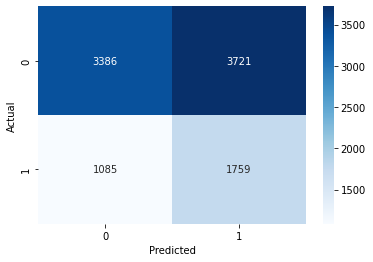

In [88]:
y_test_pred = lr_random_search.predict(X_test_sel)
plot_confusion_matrix(y_test, y_test_pred)

## KNN

In [55]:
%%time

# creating model
model = KNeighborsClassifier(weights='distance', n_jobs=-1)
pipe = Pipeline([('sc', scaler), ('clf', model)])

# define random search space
hyperparameter_random = {
    'clf__n_neighbors': randint(2, 11),  # valores aleatorios entre 2 y 10
    'clf__p': randint(1, 3)  # valores aleatorios entre 1 y 2
}

# creating randomized search for precision
knn_random_search = RandomizedSearchCV(estimator=pipe,
                                                 param_distributions=hyperparameter_random,
                                                 n_iter=100,  # máximo de 100 iteraciones
                                                 n_jobs=-1,
                                                 cv=10,
                                                 scoring='precision',  # cambiar a precision
                                                 error_score=0,
                                                 random_state=23,
                                                 return_train_score=True)
# Fit the model to the data
knn_random_search.fit(X_train_sel, y_train)

CPU times: total: 21.6 s
Wall time: 11min 10s


RandomizedSearchCV(cv=10, error_score=0,
                   estimator=Pipeline(steps=[('sc', StandardScaler()),
                                             ('clf',
                                              KNeighborsClassifier(n_jobs=-1,
                                                                   weights='distance'))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'clf__n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013CB6016140>,
                                        'clf__p': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013CA70AB460>},
                   random_state=23, return_train_score=True,
                   scoring='precision')

In [56]:
knn_random_search.best_params_

{'clf__n_neighbors': 9, 'clf__p': 2}

In [57]:
knn_metrics =  compare_base_tuner('KNN', knn_pipe, knn_random_search,
                                X_train_sel, X_test_sel, y_train, y_test)
knn_metrics

,KNN Train set,KNN Test set,KNN_TUNED Train set,KNN_TUNED Test set
Recall Score,0.976416,0.169480,0.976647,0.120956
Precision Score,0.987028,0.328114,0.987147,0.338583
F1 Score,0.981693,0.223510,0.981869,0.178238
Accuracy Score,0.990102,0.663451,0.990197,0.681238


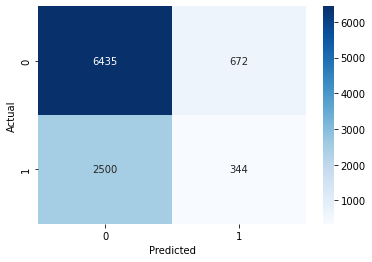

In [89]:
y_test_pred = knn_random_search.predict(X_test_sel)
plot_confusion_matrix(y_test, y_test_pred)

## Decision Tree

In [58]:
%%time

# creating model
model = DecisionTreeClassifier(class_weight='balanced', random_state=24)
pipe = Pipeline([('sc', scaler), ('clf', model)])

# define random search space
hyperparameter_random = {
    'clf__criterion': ['gini', 'entropy', 'log_loss'],
    'clf__splitter': ['best', 'random'],
    'clf__max_depth': randint(2, 16),  # random values between 2 and 15
    'clf__min_samples_split': randint(2, 11),  # random values between 2 and 10
    'clf__min_samples_leaf': randint(1, 11),  # random values between 1 and 10
    'clf__max_features': ['sqrt', 'log2']
}

# creating randomized search for precision
dtc_random_search = RandomizedSearchCV(estimator=pipe,
                                        param_distributions=hyperparameter_random,
                                        n_iter=100,  # maximum of 100 iterations
                                        n_jobs=-1,
                                        cv=10,
                                        scoring='precision',
                                        error_score=0,
                                        random_state=23,
                                        return_train_score=True)
# Fit the model to the data
dtc_random_search.fit(X_train_sel, y_train)

CPU times: total: 2.98 s
Wall time: 6.73 s


RandomizedSearchCV(cv=10, error_score=0,
                   estimator=Pipeline(steps=[('sc', StandardScaler()),
                                             ('clf',
                                              DecisionTreeClassifier(class_weight='balanced',
                                                                     random_state=24))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'clf__criterion': ['gini', 'entropy',
                                                           'log_loss'],
                                        'clf__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013CA6EE35B0>,
                                        'clf__max_features': ['sqrt', 'log2'],
                                        'clf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013CB33C0940>,
                                        'clf__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013CB6015B10>,
                                        'clf__splitter': ['best', 'random']},
                   random_state=23, return_train_score=True,
                   scoring='precision')

In [59]:
dtc_random_search.best_params_

{'clf__criterion': 'entropy',
 'clf__max_depth': 5,
 'clf__max_features': 'log2',
 'clf__min_samples_leaf': 2,
 'clf__min_samples_split': 6,
 'clf__splitter': 'best'}

In [60]:
dtc_metrics =  compare_base_tuner('DTC', dtc_pipe, dtc_random_search,
                                X_train_sel, X_test_sel, y_train, y_test)
dtc_metrics

,DTC Train set,DTC Test set,DTC_TUNED Train set,DTC_TUNED Test set
Recall Score,0.996763,0.302743,0.522428,0.509494
Precision Score,0.963460,0.312070,0.327061,0.329468
F1 Score,0.979828,0.307335,0.402279,0.400166
Accuracy Score,0.988846,0.609989,0.578049,0.563461


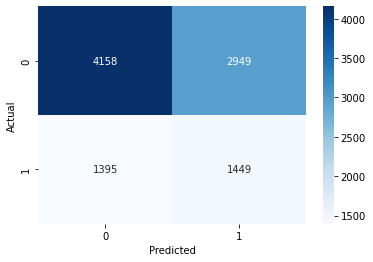

In [93]:
y_test_pred = dtc_random_search.predict(X_test_sel)
plot_confusion_matrix(y_test, y_test_pred)

## Random Forest

In [64]:
%%time

# creating model
model = RandomForestClassifier(class_weight='balanced', random_state=24)
pipe = Pipeline([('sc', scaler), ('clf', model)])

# define random search space
hyperparameter_random = {
    'clf__criterion': ['gini', 'entropy', 'log_loss'],
    'clf__max_depth': randint(2, 10),
    'clf__min_samples_split': randint(2, 11),
    'clf__min_samples_leaf': randint(1, 11),
    'clf__max_features': ['sqrt', 'log2']
}

# creating randomized search for precision
rfc_random_search = RandomizedSearchCV(estimator=pipe,
                                        param_distributions=hyperparameter_random,
                                        n_iter=100,  
                                        n_jobs=-1,
                                        cv=10,
                                        scoring='precision',
                                        error_score=0,
                                        random_state=23,
                                        return_train_score=True)
# Fit the model to the data
rfc_random_search.fit(X_train_sel, y_train)

CPU times: total: 25.8 s
Wall time: 2min 57s


RandomizedSearchCV(cv=10, error_score=0,
                   estimator=Pipeline(steps=[('sc', StandardScaler()),
                                             ('clf',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=24))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'clf__criterion': ['gini', 'entropy',
                                                           'log_loss'],
                                        'clf__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013CB3D3E170>,
                                        'clf__max_features': ['sqrt', 'log2'],
                                        'clf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013CB1E07A30>,
                                        'clf__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013CAED84FA0>},
                   random_state=23, return_train_score=True,
                   scoring='precision')

In [67]:
rfc_random_search.best_params_

{'clf__criterion': 'gini',
 'clf__max_depth': 9,
 'clf__max_features': 'sqrt',
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 3}

In [68]:
rfc_metrics = compare_base_tuner('RFC', rfc_pipe, rfc_random_search,
                                X_train_sel, X_test_sel, y_train, y_test)
rfc_metrics

,RFC Train set,RFC Test set,RFC_TUNED Train set,RFC_TUNED Test set
Recall Score,0.993295,0.084037,0.576416,0.406470
Precision Score,0.969095,0.388618,0.466679,0.354492
F1 Score,0.981046,0.138190,0.515775,0.378706
Accuracy Score,0.989568,0.700432,0.705838,0.618832


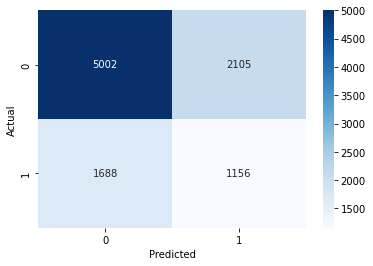

In [92]:
y_test_pred = rfc_random_search.predict(X_test_sel)
plot_confusion_matrix(y_test, y_test_pred)

## XGBoost

In [79]:
# balancing_param calculation
balancing_param = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# creating model
model = XGBClassifier(objective = 'binary:logistic',
                      eval_metric = 'logloss',
                      n_estimators = 1000,
                      scale_pos_weight = balancing_param * 1.3, 
                      random_state = 24,
                      n_jobs = -1)

pipe = Pipeline([('sc', scaler), ('clf', model)])

# define random search space
hyperparameter_random = {
    'clf__alpha': uniform(0, 1200),
    'clf__lambda': uniform(0, 1500),
    'clf__gamma': uniform(0, 10),
    'clf__max_depth': randint(3, 10),  
    'clf__max_delta_step': randint(0, 11),  # 10 + 1 for inclusive range
    'clf__subsample': uniform(0.5, 0.5),  # starting from 0.5
    'clf__min_child_weight': uniform(0, 120),
    'clf__eta': uniform(0.01, 0.89),  # 0.9 - 0.01 for inclusive range
    'clf__colsample_bytree': uniform(0.5, 0.5),  # starting from 0.5
    'clf__colsample_bynode': uniform(0.1, 0.9),  # starting from 0.1
    'clf__colsample_bylevel': uniform(0.1, 0.9),  # starting from 0.1
    'clf__rate_drop': uniform(0, 1),
    'clf__one_drop': randint(0, 2),  # 1 + 1 for inclusive range
    'clf__skip_drop': uniform(0, 1)
}

# creating randomized search for precision
xgb_random_search = RandomizedSearchCV(estimator=pipe,
                                        param_distributions=hyperparameter_random,
                                        n_iter=100,  # máximo de 100 iteraciones
                                        n_jobs=-1,
                                        cv=10,
                                        scoring='precision',
                                        error_score=0,
                                        random_state=23,
                                        return_train_score=True)

# Fit the model to the data
xgb_random_search.fit(X_train_sel, y_train)

RandomizedSearchCV(cv=10, error_score=0,
                   estimator=Pipeline(steps=[('sc', StandardScaler()),
                                             ('clf',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric='logloss',
                                                            feature_types=None,
                                                            gamma=None,
                                                            grow_policy=N...
                                        'clf__rate_drop': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000013CB5E43FD0>,
                                        'clf__skip_drop': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000013CB1FDA290>,
                                        'clf__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000013D19C31480>},
                   random_state=23, return_train_score=True,
                   scoring='precision')

In [80]:
xgb_random_search.best_params_

{'clf__alpha': 2.2964047317842073,
 'clf__colsample_bylevel': 0.14120310328984634,
 'clf__colsample_bynode': 0.28180604799634223,
 'clf__colsample_bytree': 0.7737307320842972,
 'clf__eta': 0.8007786309278301,
 'clf__gamma': 0.7552645031202909,
 'clf__lambda': 1190.2203630458514,
 'clf__max_delta_step': 4,
 'clf__max_depth': 8,
 'clf__min_child_weight': 75.15663186984013,
 'clf__one_drop': 0,
 'clf__rate_drop': 0.1552147464040412,
 'clf__skip_drop': 0.601118950323519,
 'clf__subsample': 0.8690200121507528}

In [81]:
xgb_metrics = compare_base_tuner('XGB', xgb_pipe, xgb_random_search,
                                X_train_sel, X_test_sel, y_train, y_test)
xgb_metrics

,XGB Train set,XGB Test set,XGB_TUNED Train set,XGB_TUNED Test set
Recall Score,0.943006,0.634318,0.829480,0.755626
Precision Score,0.445348,0.307902,0.319471,0.302591
F1 Score,0.604984,0.414570,0.461281,0.432134
Accuracy Score,0.665305,0.487991,0.473418,0.432419


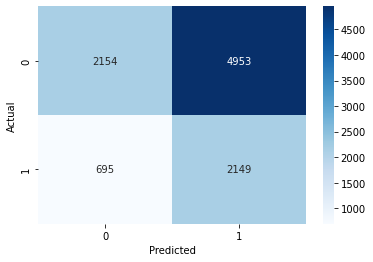

In [94]:
y_test_pred = xgb_random_search.predict(X_test_sel)
plot_confusion_matrix(y_test, y_test_pred)

## LGBM

In [82]:
# balancing_param calculation
balancing_param = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
# creating model
model = LGBMClassifier(objective = 'binary',
                       metric = 'binary_logloss',
                       scale_pos_weight = ratio * 1.3,
                       n_estimators = 1000,
                       random_state = 24, 
                       n_jobs = -1)
pipe = Pipeline([('sc', scaler), ('clf', model)])

# define search space for Bayesian optimization
hyperparameter_ranges = {
    'clf__reg_alpha': uniform(0, 1200),
    'clf__reg_lambda': uniform(0, 1200),
    'clf__num_leaves': randint(2, 101),  # 100 + 1 for inclusive range
    'clf__max_depth': randint(0, 13),  # 12 + 1 for inclusive range
    'clf__learning_rate': uniform(0.001, 0.1),
    'clf__subsample': uniform(0.5, 1),
    'clf__n_estimators': randint(50, 151),  # 150 + 1 for inclusive range
}

# creating randomized search for recall
lgbm_random_search = RandomizedSearchCV(estimator=pipe,
                                       param_distributions=hyperparameter_ranges,
                                       n_iter=100,  # máximo de 100 iteraciones
                                       n_jobs=-1,
                                       cv=10,
                                       scoring='precision',
                                       error_score=0,
                                       random_state=23,
                                       return_train_score=True)

# Fit the model to the data
lgbm_random_search.fit(X_train_sel, y_train)

[LightGBM] [Info] Number of positive: 8650, number of negative: 23176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 31826, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.271790 -> initscore=-0.985558
[LightGBM] [Info] Start training from score -0.985558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

RandomizedSearchCV(cv=10, error_score=0,
                   estimator=Pipeline(steps=[('sc', StandardScaler()),
                                             ('clf',
                                              LGBMClassifier(metric='binary_logloss',
                                                             n_estimators=1000,
                                                             n_jobs=-1,
                                                             objective='binary',
                                                             random_state=24,
                                                             scale_pos_weight=3.483098265895954))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'clf__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_f...
                                        'clf__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000013CB1DFE7D0>,
                                        'clf__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000013CB1DAFDC0>,
                                        'clf__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000013D197AE440>},
                   random_state=23, return_train_score=True,
                   scoring='precision')

In [83]:
lgbm_random_search.best_params_

{'clf__learning_rate': 0.03156001857108461,
 'clf__max_depth': 6,
 'clf__n_estimators': 134,
 'clf__num_leaves': 89,
 'clf__reg_alpha': 7.713959440012408,
 'clf__reg_lambda': 55.95585403403183,
 'clf__subsample': 0.9187424000059132}

In [84]:
lgbm_metrics = compare_base_tuner('LGBM', lgbm_pipe, lgbm_random_search,
                                X_train_sel, X_test_sel, y_train, y_test)
lgbm_metrics

,LGBM Train set,LGBM Test set,LGBM_TUNED Train set,LGBM_TUNED Test set
Recall Score,0.961734,0.822785,0.871561,0.835091
Precision Score,0.335931,0.298127,0.303356,0.300861
F1 Score,0.497935,0.437670,0.450063,0.442354
Accuracy Score,0.472884,0.395739,0.421102,0.398251


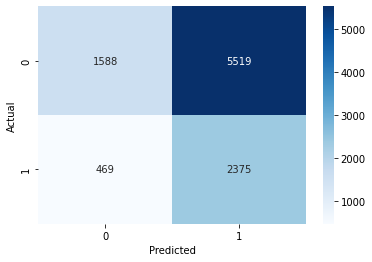

In [95]:
y_test_pred = lgbm_random_search.predict(X_test_sel)
plot_confusion_matrix(y_test, y_test_pred)

# Evaluating XGBoost and LightBGM

It can ben seen that XGBoost and LightGBM have the highest balanced between Recall and Precision from the hyperparameters tuning

In [105]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision', linewidth = 2)
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'Recall', linewidth = 2)
    plt.legend(loc = 'center right', fontsize = 16)
    plt.xlabel('Threshold', fontsize = 16)
    plt.grid(True)
    plt.show()

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b--', linewidth = 2)
    plt.xlabel('Recall', fontsize = 16)
    plt.ylabel('Precision', fontsize = 16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    plt.show()

## XGBoost

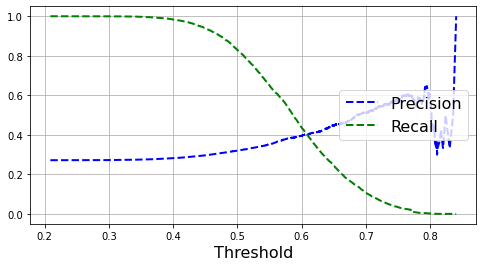

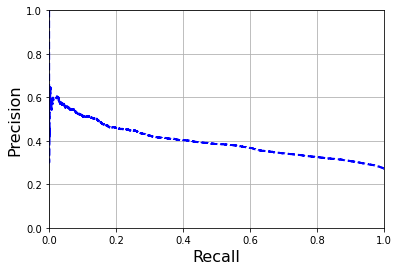

In [106]:
y_train_probs = xgb_random_search.predict_proba(X_train_sel)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_probs)

plt.figure(figsize = (8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plot_precision_vs_recall(precisions, recalls)

## LightGBM

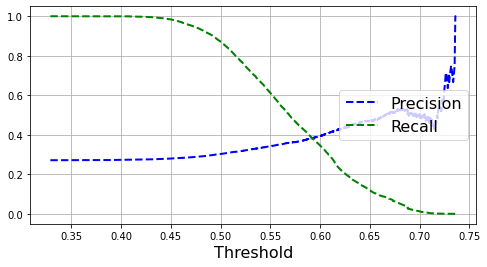

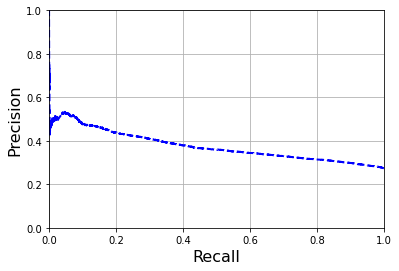

In [107]:
y_train_probs = lgbm_random_search.predict_proba(X_train_sel)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_probs)

plt.figure(figsize = (8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plot_precision_vs_recall(precisions, recalls)